EDA Content
1. Basic Data Overview
2. Target Variable Analysis / Class Distribution
3. Spectral Feature Analysis
4. Class-specific Spectral Signatures
5. Feature Correlation and Dimensionality
6. Principial Component Analysis

Executive Summary

- Dataset with 215,604 pixels (rows) and 223 features (columns)
- Complete dataset is taking up 0.4GB of memory
- Features include land type, the pixels location in a planar coordinate system, 218 different bands, and two visualization features that are irrelevant for our analysis
- There are no missing values in the dataset
- There are eight different unique values for land type, our target variable
- “Alpine meadow” is the most frequent land type with 23.5% of all pixels (Imbalance!)
- The spatial distribution map shows that land types form distinct geographic clusters rather than random patterns, with clear spatial organization across the alpine landscape.
- The class-specific spectral signatures show the that the snow/ice land type has the most distinct spectral profile
- Bands 1-50 have the highest discriminative power according to the between-class variance
- Snow/ice has the highest spectral variability (highest avg standard deviation)
- While adjacent bands are highly correlated (0.996), the overall spectral correlation across all wavelength combinations averages 0.340, indicating significant spectral diversity across the full 420-2450nm range
- There are two exceptions to this, the transitions between 129/130 and  157/158. A deep dive on the statistic on those bands, suggests that these are not due to bad measurements, but likely due to atmospheric or material absorption features.
- The task suggests to do a Principal Component Analysis with 10 components, however we can see that already with three components we can explain >99% of the variance
- The PCA plot reveals clear clustering of land types with minimal overlap, indicating strong separability that should lead to accurate classification results

1. Basic Data Overview

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
print("All Imports OK")

All Imports OK


In [93]:
# Load the data, understand shape, memory and features
df = pd.read_csv('data/data-1.csv.gz')
print(f"Full dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(list(df.columns))

Full dataset shape: (215604, 223)
Memory usage: 403.2 MB
['land_type', 'p_x', 'p_y', 'Band_1', 'Band_2', 'Band_3', 'Band_4', 'Band_5', 'Band_6', 'Band_7', 'Band_8', 'Band_9', 'Band_10', 'Band_11', 'Band_12', 'Band_13', 'Band_14', 'Band_15', 'Band_16', 'Band_17', 'Band_18', 'Band_19', 'Band_20', 'Band_21', 'Band_22', 'Band_23', 'Band_24', 'Band_25', 'Band_26', 'Band_27', 'Band_28', 'Band_29', 'Band_30', 'Band_31', 'Band_32', 'Band_33', 'Band_34', 'Band_35', 'Band_36', 'Band_37', 'Band_38', 'Band_39', 'Band_40', 'Band_41', 'Band_42', 'Band_43', 'Band_44', 'Band_45', 'Band_46', 'Band_47', 'Band_48', 'Band_49', 'Band_50', 'Band_51', 'Band_52', 'Band_53', 'Band_54', 'Band_55', 'Band_56', 'Band_57', 'Band_58', 'Band_59', 'Band_60', 'Band_61', 'Band_62', 'Band_63', 'Band_64', 'Band_65', 'Band_66', 'Band_67', 'Band_68', 'Band_69', 'Band_70', 'Band_71', 'Band_72', 'Band_73', 'Band_74', 'Band_75', 'Band_76', 'Band_77', 'Band_78', 'Band_79', 'Band_80', 'Band_81', 'Band_82', 'Band_83', 'Band_84', 

In [94]:
# Understand data types
print(df.dtypes)
print(df.dtypes.value_counts())

land_type       object
p_x              int64
p_y              int64
Band_1         float64
Band_2         float64
                ...   
Band_216       float64
Band_217       float64
Band_218       float64
rgb_hex         object
overlay_hex     object
Length: 223, dtype: object
float64    218
object       3
int64        2
Name: count, dtype: int64


In [95]:
# Check missing values
nan_counts = df.isnull().sum()
nan_counts[nan_counts > 0]

Series([], dtype: int64)

2. Target Variable Analysis / Class Distribution

                       Count  Percentage
land_type                               
alpine meadow          50657       23.50
alpine tundra          38900       18.04
valley floor / meadow  38424       17.82
bare rock              26314       12.20
veg-scree mix          24495       11.36
scree / sunlit rock    15153        7.03
snow / ice             11533        5.35
dark rock              10128        4.70


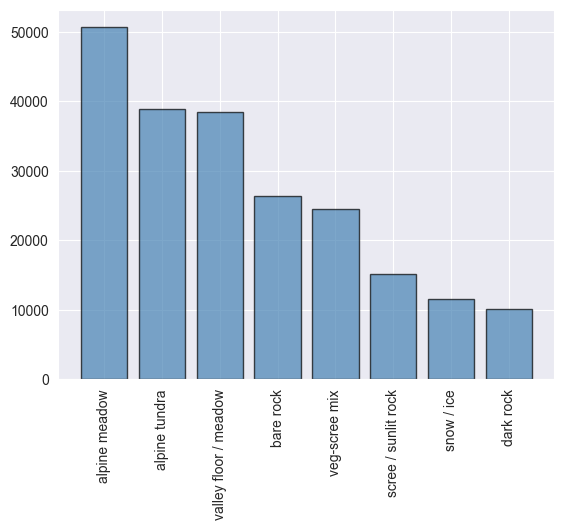

In [96]:
# Exploring the "land_type" column
land_type_counts = df['land_type'].value_counts().sort_values(ascending=False)
land_type_percent = (land_type_counts / len(df) * 100).round(2)

result_table = pd.DataFrame({
    'Count': land_type_counts,
    'Percentage': land_type_percent
})
print(result_table)

plt.bar(range(len(land_type_counts)), land_type_counts.values,
        color='steelblue', alpha=0.7, edgecolor='black')
plt.xticks(range(len(land_type_counts)), land_type_counts.index, rotation=90);


In [97]:
# Factorizing the categorical variable

le = LabelEncoder()
df['land_type_encoded'] = le.fit_transform(df['land_type'])

print(dict(zip(le.classes_, le.transform(le.classes_))))

{'alpine meadow': np.int64(0), 'alpine tundra': np.int64(1), 'bare rock': np.int64(2), 'dark rock': np.int64(3), 'scree / sunlit rock': np.int64(4), 'snow / ice': np.int64(5), 'valley floor / meadow': np.int64(6), 'veg-scree mix': np.int64(7)}


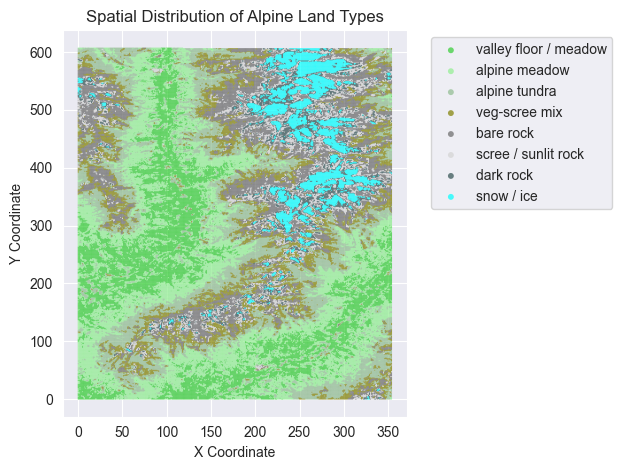

In [98]:
# Create spatial distribution visualization

color_mapping = {
    'alpine meadow': 'lightgreen',
    'alpine tundra': 'darkseagreen',
    'valley floor / meadow': 'limegreen',
    'bare rock': 'dimgray',
    'veg-scree mix': 'olive',
    'scree / sunlit rock': 'lightgray',
    'snow / ice': 'cyan',
    'dark rock': 'darkslategray'
}

for land_type in df['land_type'].unique():
    mask = df['land_type'] == land_type
    color = color_mapping[land_type]
    plt.scatter(df.loc[mask, 'p_x'], df.loc[mask, 'p_y'],
               c=color, label=land_type, alpha=0.7, s=0.5,
               edgecolors='none')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Spatial Distribution of Alpine Land Types')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=6)
plt.tight_layout()
plt.show()

3. Spectral Feature Analysis

In [99]:
# Define band columns and spectral data
band_cols = [col for col in df.columns if col.startswith('Band_')]
spectral_data = df[band_cols]

print(f"Number of spectral bands: {len(band_cols)}")
print(f"Spectral data shape: {spectral_data.shape}")

# Calculate statistics for each band
band_means = spectral_data.mean(axis=0)
band_stds = spectral_data.std(axis=0)
band_mins = spectral_data.min(axis=0)
band_maxs = spectral_data.max(axis=0)

# Create the summary table
print(f"\nBand Statistics Summary (across all {len(band_cols)} bands):")
print(f"{'Statistic':<10} {'Min':<12} {'Max':<12}")
print("-" * 35)
print(f"{'Count':<10} {len(band_cols):<12} {len(band_cols):<12}")
print(f"{'Mean':<10} {band_means.min():<12.5f} {band_means.max():<12.5f}")
print(f"{'Std':<10} {band_stds.min():<12.5f} {band_stds.max():<12.5f}")
print(f"{'Min':<10} {band_mins.min():<12.5f} {band_mins.max():<12.5f}")
print(f"{'Max':<10} {band_maxs.min():<12.5f} {band_maxs.max():<12.5f}")

Number of spectral bands: 218
Spectral data shape: (215604, 218)

Band Statistics Summary (across all 218 bands):
Statistic  Min          Max         
-----------------------------------
Count      218          218         
Mean       0.08410      0.32921     
Std        0.05500      0.17428     
Min        -0.09120     0.01070     
Max        0.41120      1.61380     


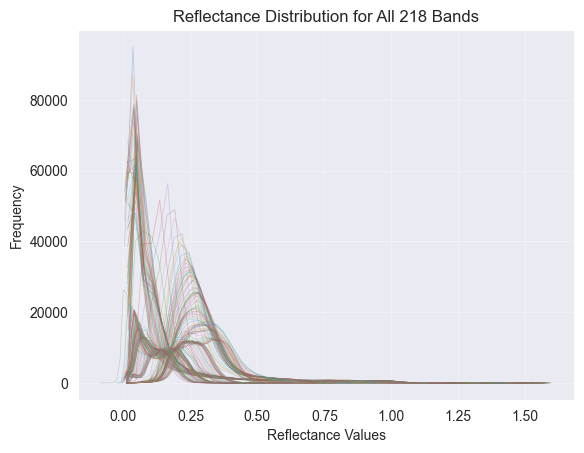

In [100]:
# Plot histogram for each of the 218 bands
for i, band in enumerate(band_cols):
    counts, bins = np.histogram(df[band], bins=50)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, counts, alpha=0.3, linewidth=0.5)

plt.xlabel('Reflectance Values')
plt.ylabel('Frequency')
plt.title('Reflectance Distribution for All 218 Bands')
plt.grid(True, alpha=0.3)
plt.show()

4. Class-specific spectral signatures

In [101]:
# Calculate mean reflectance per land type per band
spectral_means_by_class = df.groupby('land_type')[band_cols].mean()
spectral_stds_by_class = df.groupby('land_type')[band_cols].std()

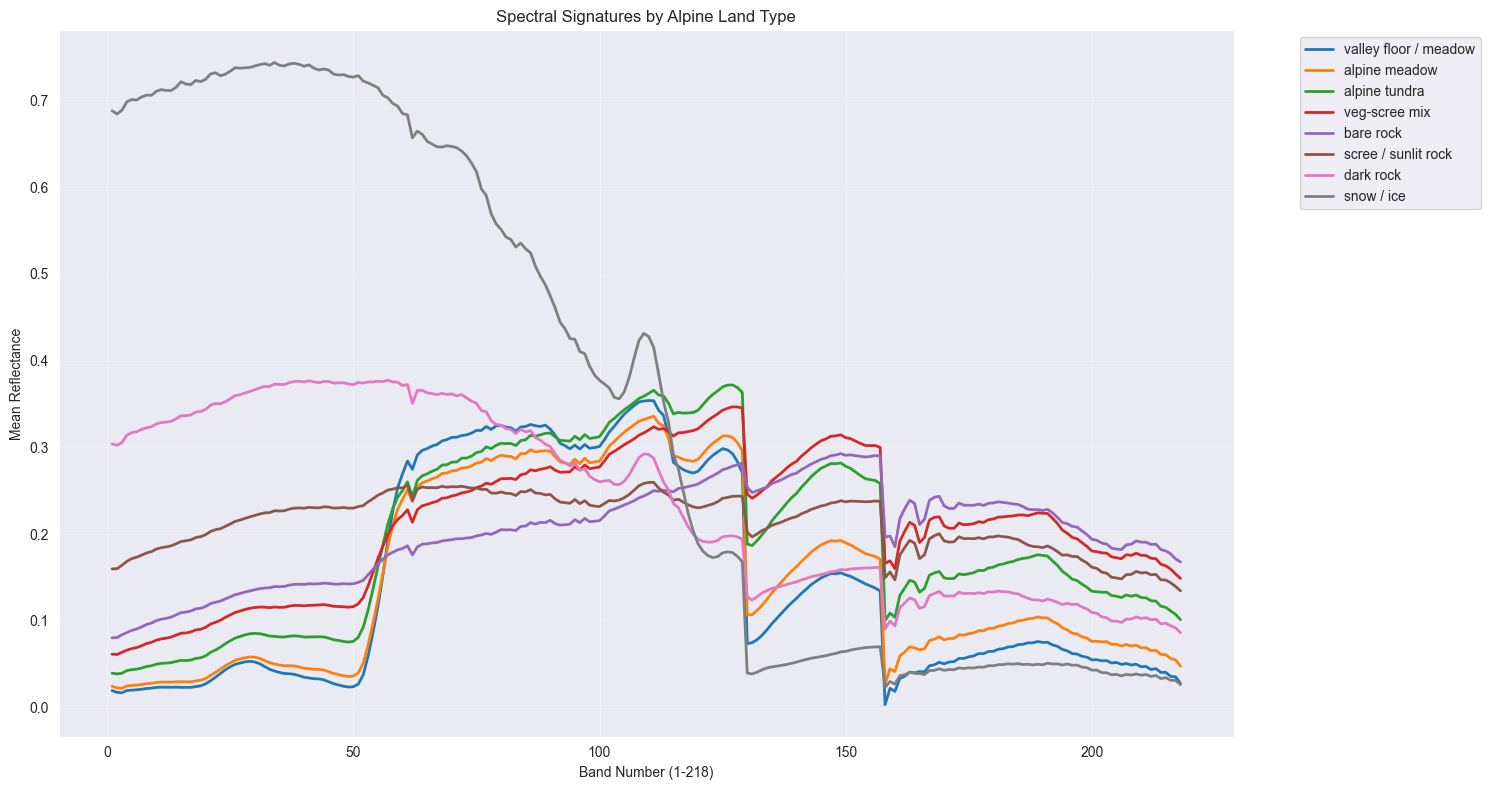

In [102]:
# Plot spectral signatures for all 8 land types
plt.figure(figsize=(15, 8))

for land_type in df['land_type'].unique():
    mean_signature = spectral_means_by_class.loc[land_type]
    plt.plot(range(1, len(band_cols)+1), mean_signature,
             label=land_type, linewidth=2)

plt.xlabel('Band Number (1-218)')
plt.ylabel('Mean Reflectance')
plt.title('Spectral Signatures by Alpine Land Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

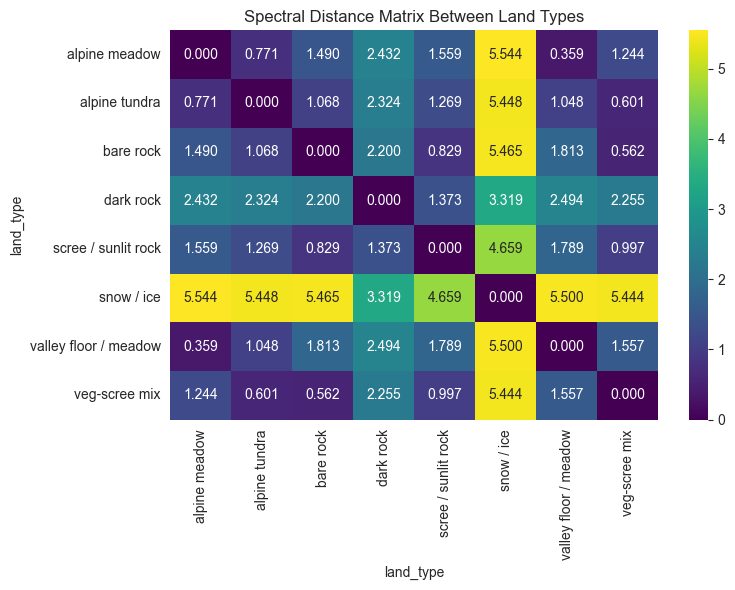

In [103]:
# Calculate spectral distance between land types
distances = pdist(spectral_means_by_class.values, metric='euclidean')
distance_matrix = squareform(distances)

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(distance_matrix,
                        index=spectral_means_by_class.index,
                        columns=spectral_means_by_class.index),
           annot=True, fmt='.3f', cmap='viridis')
plt.title('Spectral Distance Matrix Between Land Types')
plt.tight_layout()

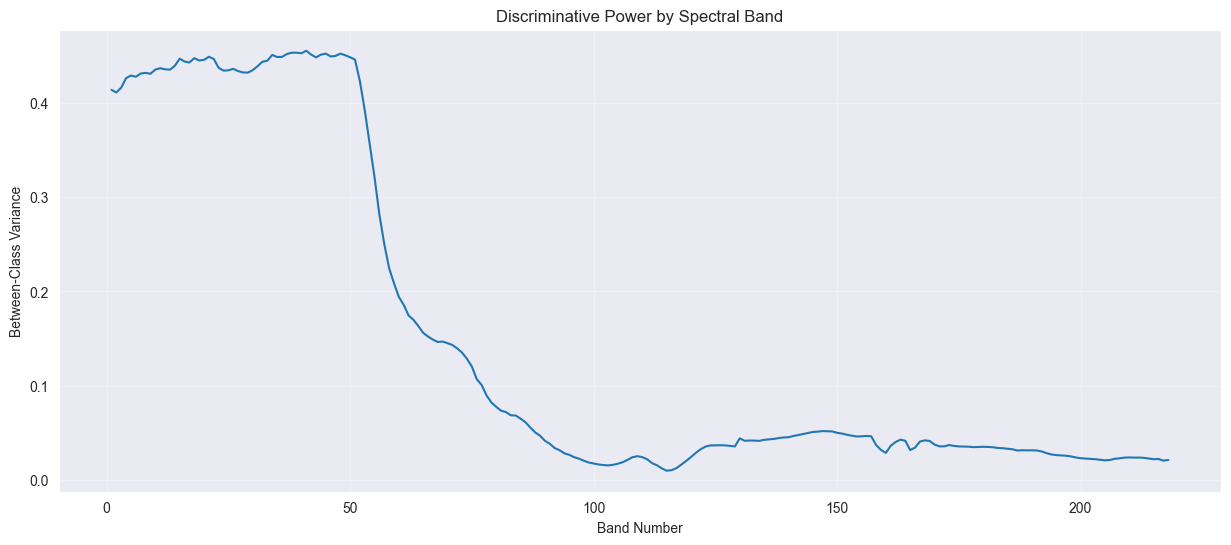

In [104]:
# Calculate between-class variance for all bands
band_separability = []
for band in band_cols:
    class_means = df.groupby('land_type')[band].mean()
    overall_mean = df[band].mean()
    between_var = ((class_means - overall_mean) ** 2).sum()
    band_separability.append(between_var)

plt.figure(figsize=(15, 6))
plt.plot(range(1, len(band_cols)+1), band_separability)
plt.xlabel('Band Number')
plt.ylabel('Between-Class Variance')
plt.title('Discriminative Power by Spectral Band')
plt.grid(True, alpha=0.3)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'veg-scree mix'),
  Text(1, 0, 'alpine tundra'),
  Text(2, 0, 'alpine meadow'),
  Text(3, 0, 'bare rock'),
  Text(4, 0, 'valley floor / meadow'),
  Text(5, 0, 'scree / sunlit rock'),
  Text(6, 0, 'dark rock'),
  Text(7, 0, 'snow / ice')])

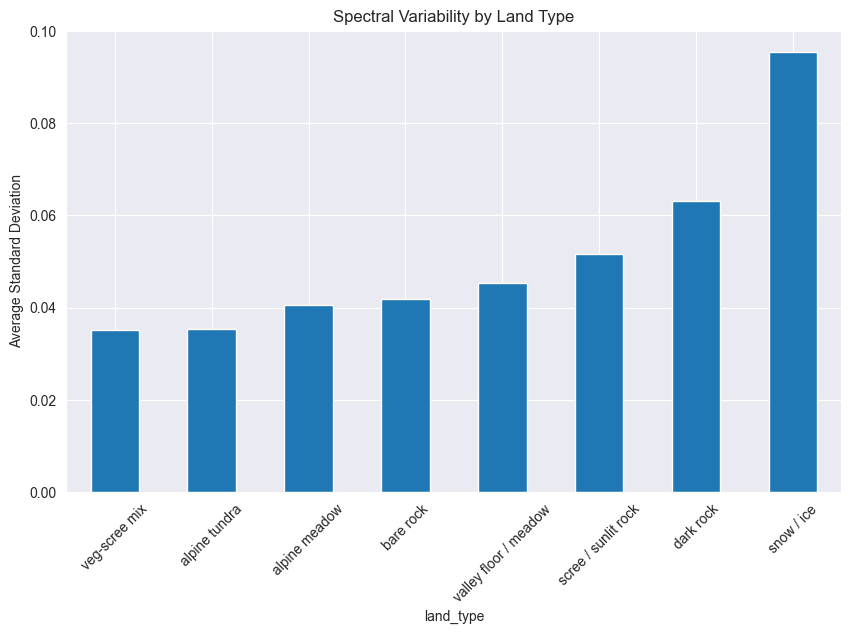

In [105]:
# Show which land types are most spectrally variable
class_variability = spectral_stds_by_class.mean(axis=1).sort_values()
plt.figure(figsize=(10, 6))
class_variability.plot(kind='bar')
plt.title('Spectral Variability by Land Type')
plt.ylabel('Average Standard Deviation')
plt.xticks(rotation=45)

55. Feature Correlation

In [106]:
# Calculate correlation matrix for all 218 bands
correlation_matrix = spectral_data.corr()

print(f"Correlation matrix shape: {correlation_matrix.shape}")
print(f"Average correlation between bands: {correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].mean():.3f}")

Correlation matrix shape: (218, 218)
Average correlation between bands: 0.340


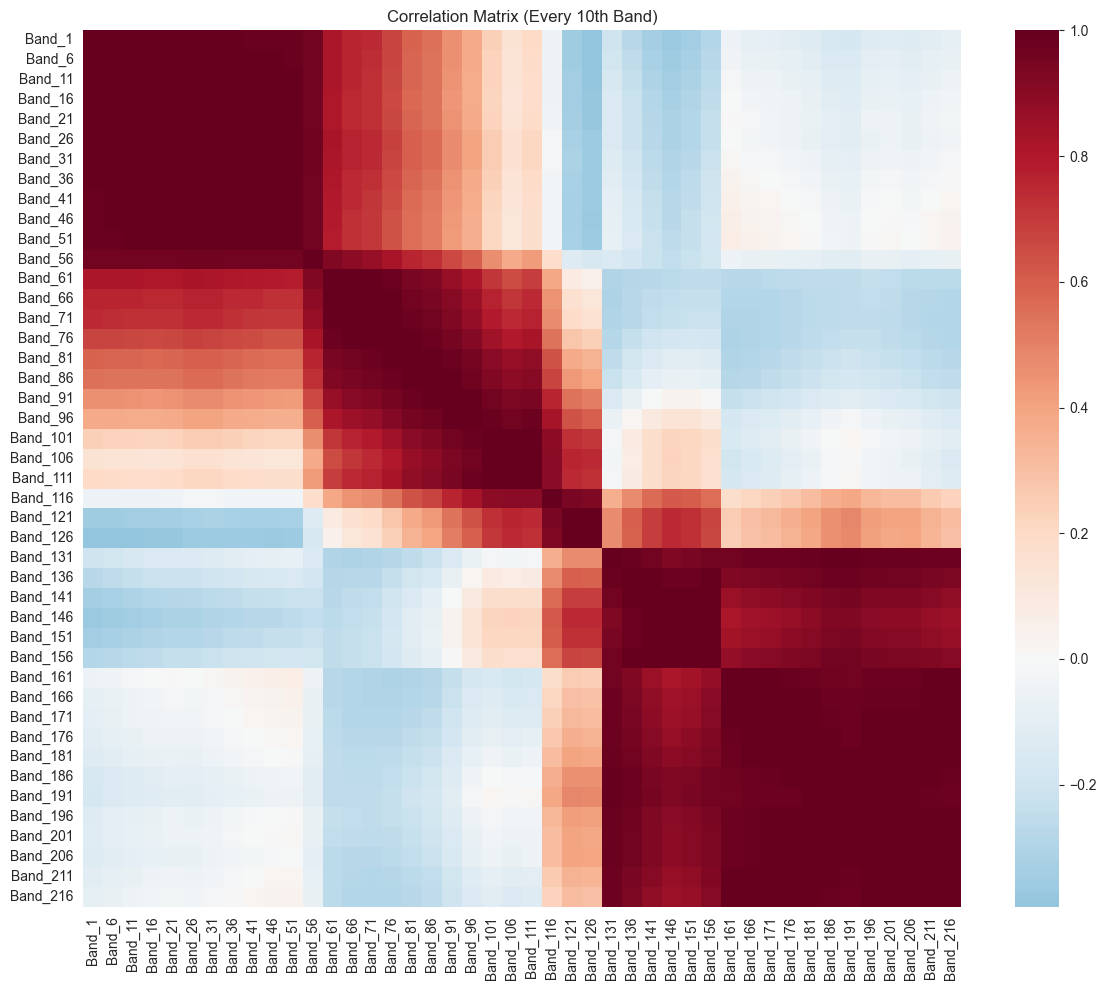

In [107]:
# Show correlation for every 5th band
selected_bands = band_cols[::5]
subset_corr = spectral_data[selected_bands].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(subset_corr, annot=False, cmap='RdBu_r', center=0,
            xticklabels=[f'Band_{i+1}' for i in range(0, len(band_cols), 5)],
            yticklabels=[f'Band_{i+1}' for i in range(0, len(band_cols), 5)])
plt.title('Correlation Matrix (Every 10th Band)')
plt.tight_layout()

Average adjacent band correlation: 0.996


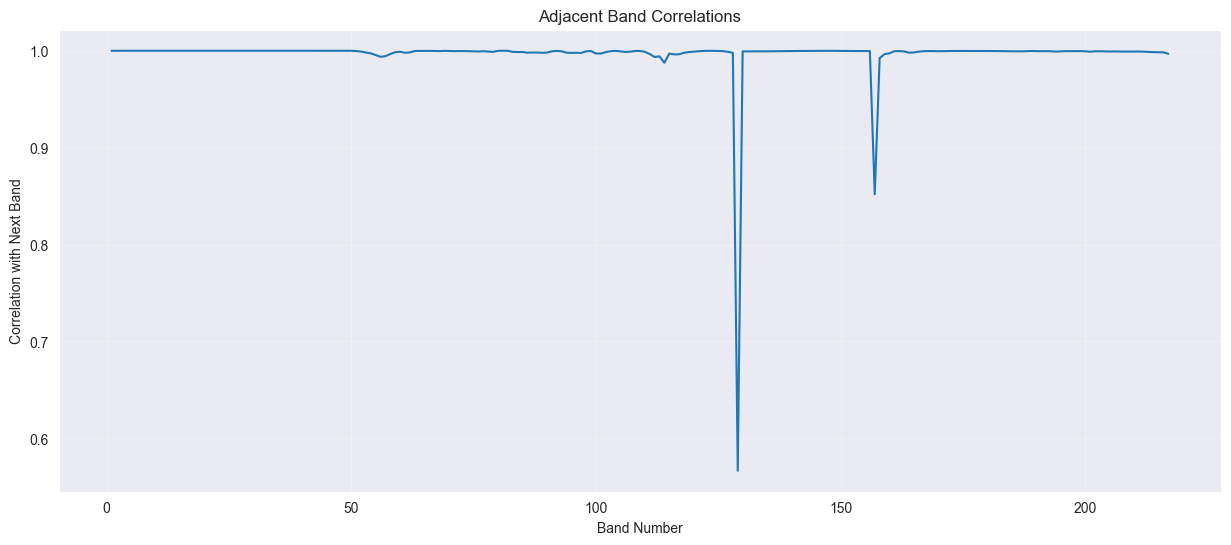

In [108]:
# Check correlation between neighboring bands
adjacent_correlations = []
for i in range(len(band_cols)-1):
    corr = spectral_data.iloc[:, i].corr(spectral_data.iloc[:, i+1])
    adjacent_correlations.append(corr)

plt.figure(figsize=(15, 6))
plt.plot(range(1, len(adjacent_correlations)+1), adjacent_correlations)
plt.xlabel('Band Number')
plt.ylabel('Correlation with Next Band')
plt.title('Adjacent Band Correlations')
plt.grid(True, alpha=0.3)
print(f"Average adjacent band correlation: {np.mean(adjacent_correlations):.3f}")

In [109]:
# Find outliers
adj_corr = np.array(adjacent_correlations)
mean_corr = adj_corr.mean()
std_corr = adj_corr.std()
threshold = mean_corr - 2 * std_corr  # 2 standard deviations below mean

outlier_indices = np.where(adj_corr < threshold)[0]
outlier_bands = []

for idx in outlier_indices:
    band1 = band_cols[idx]
    band2 = band_cols[idx + 1]
    correlation = adj_corr[idx]
    outlier_bands.append((idx+1, band1, band2, correlation))

print("Outlier Band Transitions (Low Adjacent Correlations):")
print(f"{'Band #':<8} {'Band 1':<10} {'Band 2':<10} {'Correlation':<12}")
print("-" * 45)
for band_num, b1, b2, corr in outlier_bands:
    print(f"{band_num:<8} {b1:<10} {b2:<10} {corr:<12.4f}")


Outlier Band Transitions (Low Adjacent Correlations):
Band #   Band 1     Band 2     Correlation 
---------------------------------------------
129      Band_129   Band_130   0.5667      
157      Band_157   Band_158   0.8519      


In [110]:
# Examine the problematic bands specifically
problem_bands = ['Band_129', 'Band_157', 'Band_130', 'Band_158']

print("Statistics for problematic bands:")
for band in problem_bands:
    if band in df.columns:
        stats = df[band].describe()
        print(f"\n{band}:")
        print(f"  Mean: {stats['mean']:.4f}, Std: {stats['std']:.4f}")
        print(f"  Min: {stats['min']:.4f}, Max: {stats['max']:.4f}")
        print(f"  Missing values: {df[band].isnull().sum()}")

Statistics for problematic bands:

Band_129:
  Mean: 0.2922, Std: 0.0829
  Min: 0.0054, Max: 0.7147
  Missing values: 0

Band_157:
  Mean: 0.2082, Std: 0.0829
  Min: 0.0090, Max: 0.6430
  Missing values: 0

Band_130:
  Mean: 0.1535, Std: 0.0796
  Min: -0.0140, Max: 0.5943
  Missing values: 0

Band_158:
  Mean: 0.0841, Std: 0.0751
  Min: -0.0912, Max: 0.5162
  Missing values: 0


The statistics suggest that these two bands are discriminant spectral features, not measurement errors.
There is a big drop in reflectance between 129/130 and 157/158. This might be due to atmospheric or material absorption features

g6. Principial Component Analysis
- We are tasked to do it with 10, but normally we would run a Explained Variance Ratio test, to see how much of the Variance is explained by how many components. Normally 95% of variance is okay and 99% is conservative

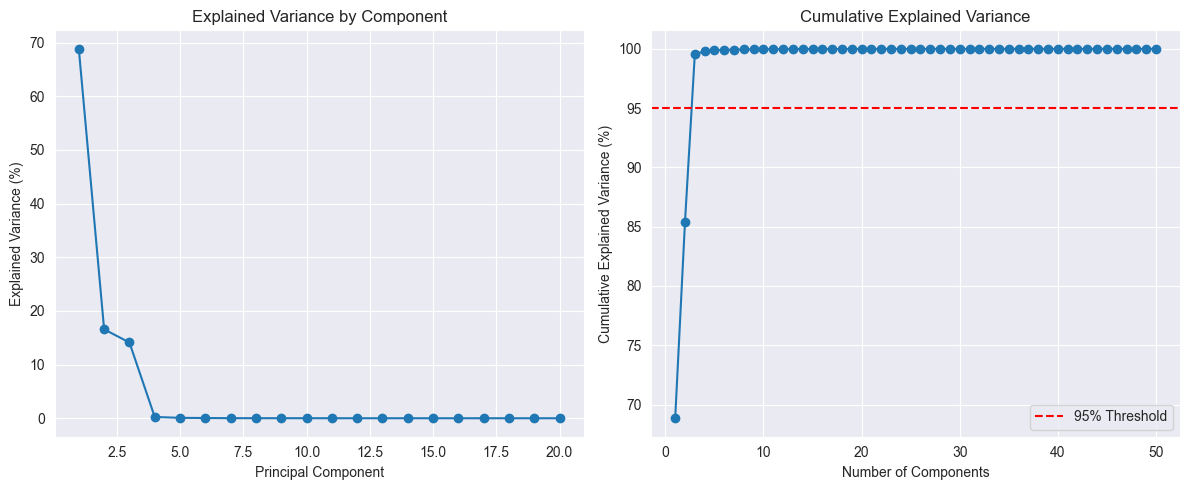

In [111]:
lpca_full = PCA()
pca_full.fit(spectral_data)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 21), pca_full.explained_variance_ratio_[:20] * 100, 'o-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance by Component')

plt.subplot(1, 2, 2)
cumsum = np.cumsum(pca_full.explained_variance_ratio_[:50]) * 100
plt.plot(range(1, 51), cumsum, 'o-')
plt.axhline(y=95, color='r', linestyle='--', label='95% Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.legend()
plt.title('Cumulative Explained Variance')
plt.tight_layout()

In [112]:
# Show Variance for First 10 Components
first_10_components = pca_full.explained_variance_ratio_[:10] * 100

print("Exact Explained Variance for First 10 Components:")
print("-" * 50)
for i, variance in enumerate(first_10_components, 1):
    print(f"PC{i}: {variance:.2f}%")

print(f"\nCumulative sum of first 10: {first_10_components.sum():.2f}%")

Exact Explained Variance for First 10 Components:
--------------------------------------------------
PC1: 68.85%
PC2: 16.58%
PC3: 14.12%
PC4: 0.24%
PC5: 0.08%
PC6: 0.05%
PC7: 0.02%
PC8: 0.01%
PC9: 0.01%
PC10: 0.01%

Cumulative sum of first 10: 99.96%


This shows that the first component explains roughly 69% of the variance, the second one roughly 16%, the third 14%. With just three components we can explain >99% of the variance already.

Text(0.5, 0.92, '3D PCA Visualization (PC1, PC2, PC3)')

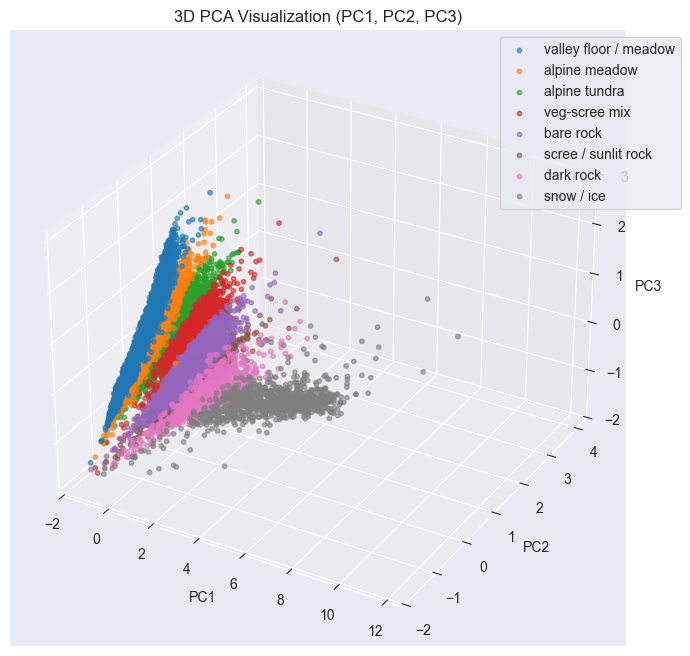

In [113]:
# Create visualization of PCA

pca_10 = PCA(n_components=10)
pca_data_10 = pca_10.fit_transform(spectral_data)

# Sample for visualization
sample_indices = np.random.choice(len(df), 20000, replace=False)
sample_pca = pca_data_10[sample_indices]
sample_labels = df.iloc[sample_indices]['land_type']# 3D plot with first 3 components

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for land_type in df['land_type'].unique():
    mask = sample_labels == land_type
    ax.scatter(sample_pca[mask, 0], sample_pca[mask, 1], sample_pca[mask, 2],
               label=land_type, alpha=0.6, s=10)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend(bbox_to_anchor=(1.1, 1))
plt.title('3D PCA Visualization (PC1, PC2, PC3)')